# EEG PreProcessing for Hyper Alignment Project

Try stuff. 

ToDo:
- Sanity check ordering of pre-processing
- finish up to run ICA & AutoReject & bad channels
- add selection of only correct trials
- drop the empty channels
- make this feature agnostic [0.1-30]

- Note: need to enforce the same number of trials per condtion per subject
    - Minimum accuracy, per condition
        - Subject below (in any condition): dropped
    - End point: n trials cond A, m trials cond B, ...., 
        - Each subject has the same n * m * sampling_rate length 2D matrix

In [187]:
%matplotlib inline

import os
import csv
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import mne

# MNE associated & pre-processing code
from mne.preprocessing import ICA
from autoreject import AutoReject

In [188]:
# ## Functions
# def org_files(files):
#     """Get the preprocessed, EEG data file names (csv format) a specified subject."""

#     eeg = [fi for fi in files if 'events' not in fi]
#     evs = [fi for fi in files if 'events' in fi]

#     # Quick hack to ignore subjs with problematic files
#     if not len(eeg) == len(evs):
#         print('Oh Shit. Something seems to have gone wrong.')
#         return None, None

#     return eeg, evs

def get_files(files, seq):
    """Return specified file type from list of files.
    Note: scrappy implementation - returns only first found file that matches pattern. 
    """
    
    for file in files:
        if seq in file:
            return file

## Load Data

Dataset description:

The EEG data used is a database collected and made available by the Child Mind Institute.

It is part of the Multimodal Resource for Studying Information Processing in the Developing Brain (MIPDB) database.

MIPDB Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/

EEG Data Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/eeg.html

In [189]:
# Set data path
data_path = '/home/andrew/HyperEEG_Data/'
# ToDo: general stuff to get a list of available subjects

In [190]:
# Set subject to load
subj = 'A00062279'
subj_path = os.path.join(data_path, subj, 'EEG', 'raw', 'raw_format')

In [191]:
# Get list of subject files
subj_files = os.listdir(subj_path)

# Restrict to only data files (avoids hidden files, etc)
subj_files = [file for file in subj_files if '.raw' in file]
subj_files

['A00062279010.raw',
 'A00062279003.raw',
 'A00062279.raw.IMP',
 'A00062279.raw.GAIN',
 'A00062279012.raw',
 'A00062279002.raw',
 'A00062279009.raw',
 'A00062279011.raw',
 'A00062279007.raw',
 'A00062279008.raw',
 'A00062279005.raw',
 'A00062279001.raw',
 'A00062279004.raw']

In [192]:
# Set the files to be loaded
f_nums = ['06.raw', '08.raw', '10.raw']

# Note: general case, this will be read from a file

In [40]:
# Get specific block
# Note: to be updated post FileOrg Steps.
#  Note: want to start with contrast change detection: '006', 008', '010'

raws = []
for f_num in f_nums:
    try:
        raw_file = get_files(subj_files, f_num)
        raws.append(mne.io.read_raw_egi(os.path.join(subj_path, raw_file), preload=True))
    except:
        pass

if len(raws) == 0:
    raise ValueError('There are no valid blocks for this subject.')

Reading EGI header from /home/andrew/HyperEEG_Data/A00062279/EEG/raw/raw_format/A00062279008.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {101 , 102 , 103 , 104 , 106 , 108 , 109 , 11  , 14  , 15  , 16  , 17  , 18  , 20  , 21  , 22  , 23  , 24  , 25  , 26  , 27  , 28  , 30  , 31  , 32  , 33  , 34  , 35  , 4   , 50  , 81  , 82  , 83  , 84  , 86  , 90  , 91  , 92  , 93  , 94  , 95  , 96  , 97  , 98  , 99  , 9999} ...
Reading 0 ... 111826  =      0.000 ...   223.652 secs...
Reading EGI header from /home/andrew/HyperEEG_Data/A00062279/EEG/raw/raw_format/A00062279010.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {101 , 102 , 103 , 104 , 106 , 108 , 109 , 11  , 14  , 15  , 16  , 17  , 18  , 20  , 21  , 22  , 23  , 24  , 25  , 26  , 27  , 28  , 30  , 31  , 32  , 33  , 34  , 35  , 4   , 50  , 81  , 82  , 83  , 84  , 86 

In [10]:
# # Sanity check consistency
# for raw in raws:
#     if raw.event_id != event_mapping:
#         print(raw.event_id)
#         raise ValueError("WARNING: event mapping issue.")

In [193]:
# Check event codes present from the file
set(mne.find_events(raws[0])[:, 2])

148 events found
Event IDs: [1 2 3 4 5]


{1, 2, 3, 4, 5}

## Set up Data


### Montage

In [194]:
# ToDo: Solve the E129 mystery
#  Note: this might be easier to load the channel file packaged with the dataset

In [195]:
# Load standard montage
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=raws[0].ch_names)

for raw in raws:
    raw.set_montage(montage)

    # Hack for 129
    raw.set_channel_types({'E129': 'misc'})

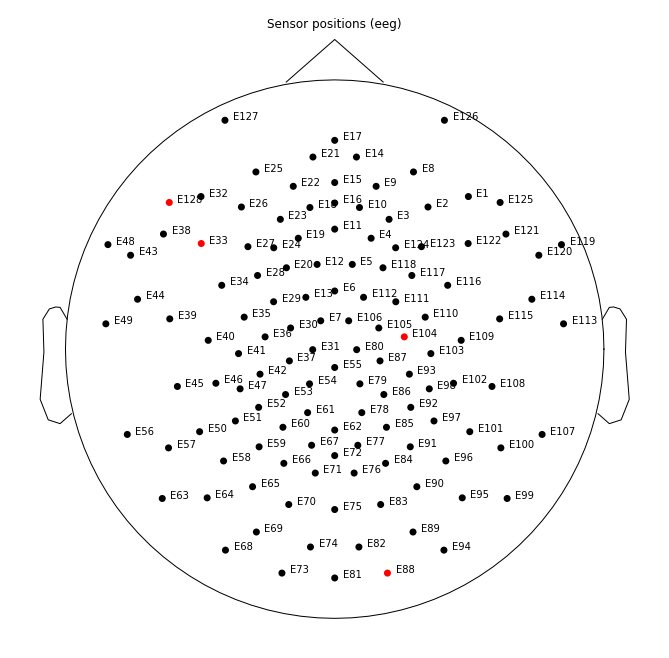

In [218]:
# Check channel locations
fig, ax = plt.subplots(figsize=[9, 9]);
raws[0].plot_sensors(show_names=True, axes=ax);

## Inspect data

In [197]:
raw_object = raws[0]

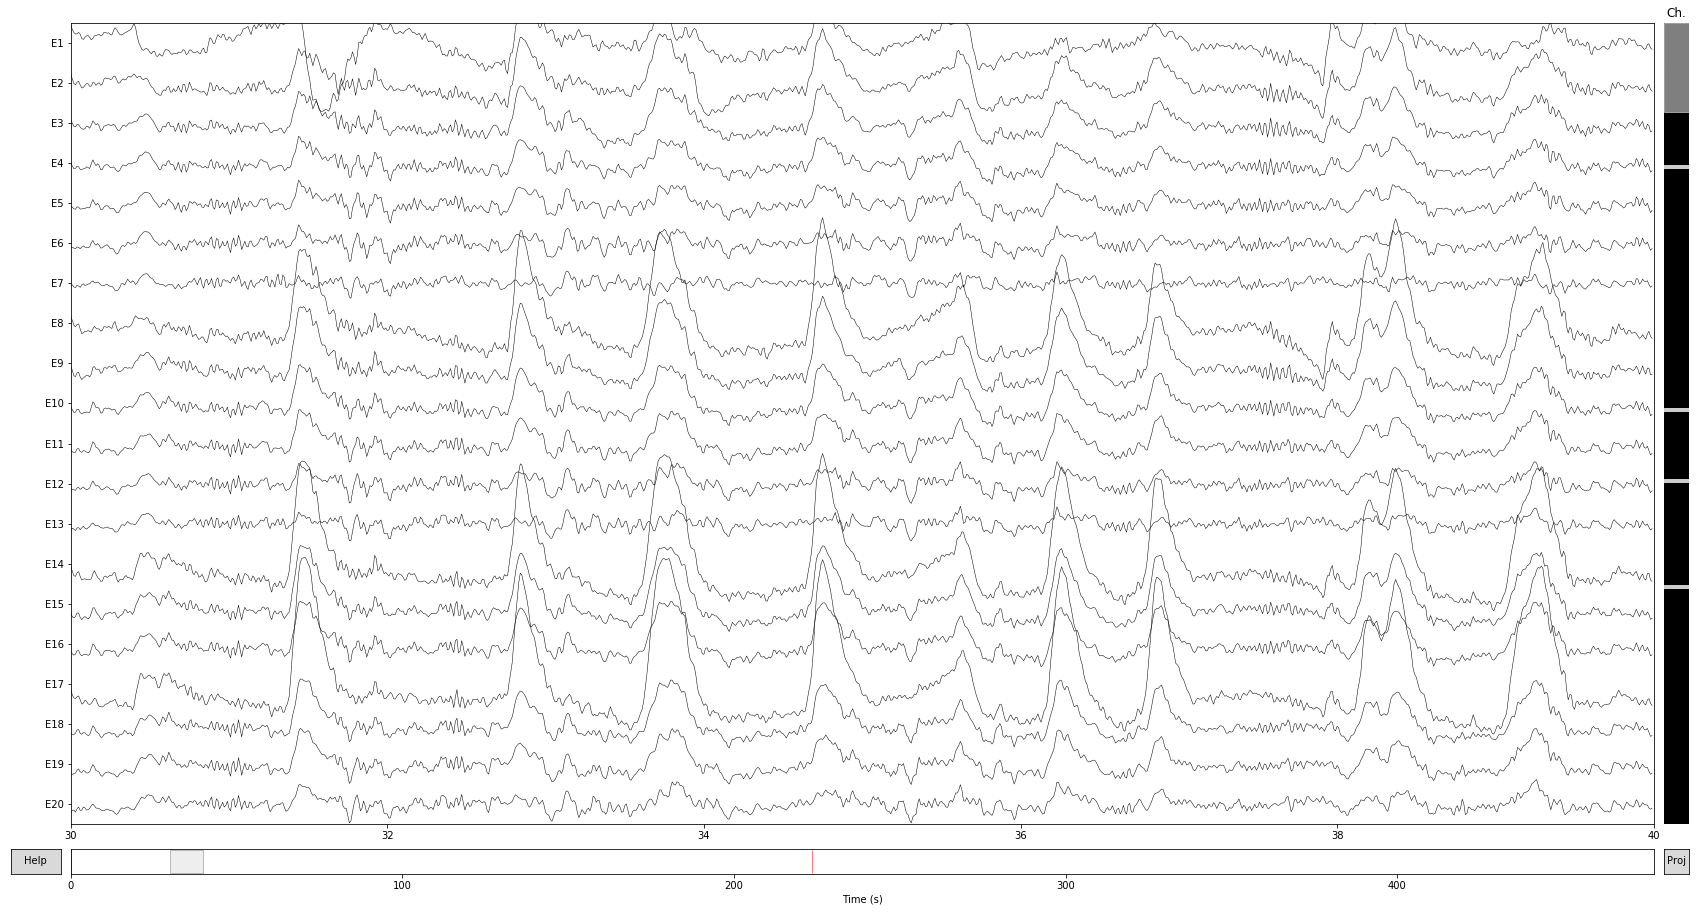

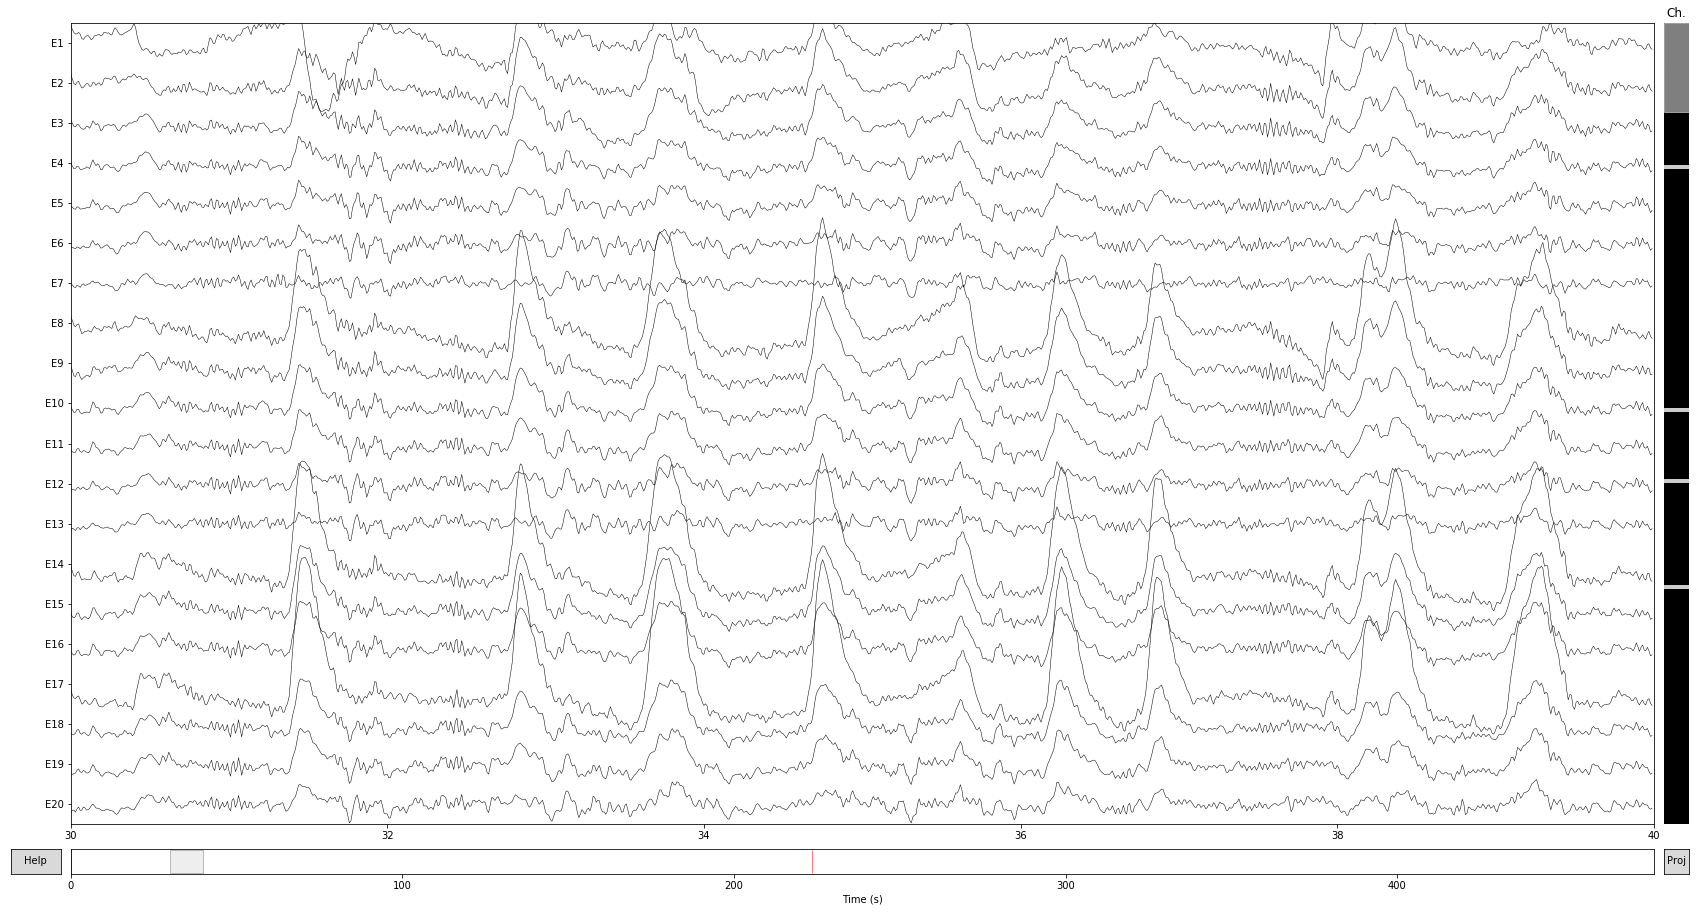

In [198]:
# Print out a small snippet of data
raw_object.plot(events=None, duration=10.0, start=30.0, n_channels=20)

Effective window size : 4.096 (s)


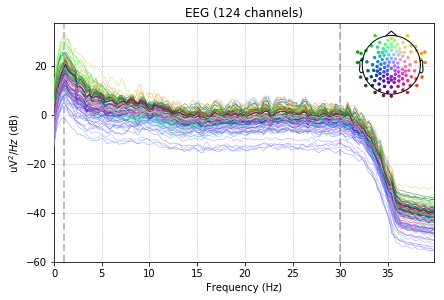

In [199]:
# Check the power spectrum of each channel
raws[0].plot_psd(tmin=30, fmin=0, fmax=40, dB=True);

## Pre-Processing

Run pre-processing on the data. 

In [90]:
# Note we might need to add something about bad channels here

In [200]:
# High pass filter
for raw in raws:
    raw.filter(l_freq=1., h_freq=30., fir_design='firwin')

Setting up band-pass filter from 1 - 30 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (3.302 sec) selected
Setting up band-pass filter from 1 - 30 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (3.302 sec) selected
Setting up band-pass filter from 1 - 30 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (3.302 sec) selected


### Sanity check after filtering

Effective window size : 4.096 (s)


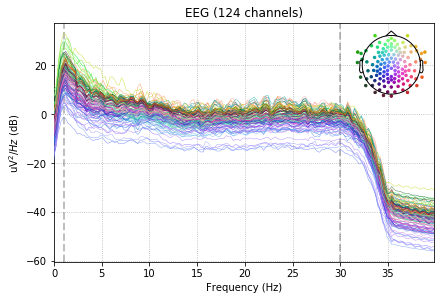

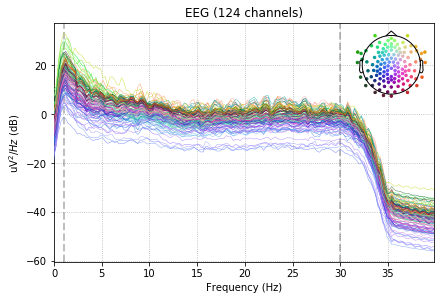

In [201]:
raws[0].plot_psd(tmin=30, fmin=0, fmax=40, dB=True)

In [202]:
# Combine raw objects into a new, single raw object
raw = mne.concatenate_raws(raws)

ValueError: raw[1]['info']['bads'] must match

### Events & Epoching

Event code descriptions:
- 3 :  5  = start trial
- 4 :  8  = Target ON left
- 5 :  9  = Target ON right
- 1 : 12  = button press left
- 2 : 13  = button press right

In [79]:
# Check event code mapping
raw.event_id

{'12  ': 1, '13  ': 2, '5   ': 3, '8   ': 4, '9   ': 5}

In [83]:
# Check events
events = mne.find_events(raw)
Counter(events[:, 2])

148 events found
Event IDs: [1 2 3 4 5]


Counter({3: 50, 5: 24, 2: 25, 4: 24, 1: 25})

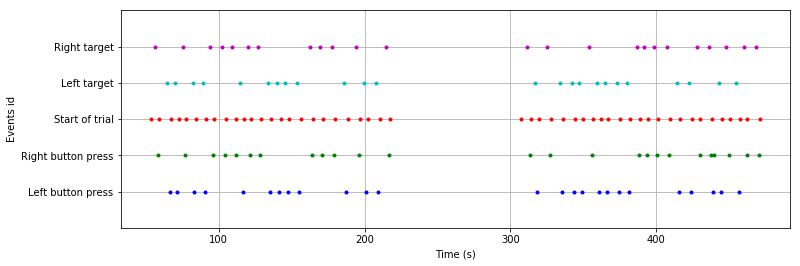

In [95]:
# Check event codes
fig, ax = plt.subplots(figsize=[12, 4])
_ = mne.viz.plot_events(events, raw.info['sfreq'], axes=ax, show=False)
ax.set_yticklabels(['Left button press', 'Right button press', 'Start of trial', 'Left target', 'Right target']);

## Construct new epochs based on combination of stimuli and correct responses

In [117]:
# Event code descriptions
trgts = [4, 5]
rspns = [1, 2]

# Create correct-response events
from mne.event import define_target_events

sfreq = raw.info['sfreq']  # sampling rate
tmin = -2.  # trials leading to very early responses will be rejected
tmax = 0.  # ignore face stimuli followed by button press later than 2 s
correct_trials = [21, 22] # new event ids for correct responses.

new_events = [] # list of new event objects
for idx in range(2):
    tmp, _ = define_target_events(events, rspns[idx], trgts[idx], sfreq, tmin, tmax, correct_trials[idx], fill_na=None)
    new_events.append(tmp)

# collapse new events into an array
new_events = np.concatenate((np.array(new_events[0]), np.array(new_events[1])), axis=0)
new_event_ids = dict(left=21, right=22)

In [119]:
print(Counter(new_events[:, -1]))

Counter({21: 24, 22: 22})


In [146]:
# Epoch data and equalize counts
baseline = (0.5, None)
epochs = mne.Epochs(raw, new_events, new_event_ids, tmin=-1, tmax=1, picks=None, baseline=baseline, reject=None)
epochs.equalize_event_counts(new_event_ids, method='mintime')

The events passed to the Epochs constructor are not chronologically ordered.
46 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 46 events and 1001 original time points ...


<ipython-input-146-767ad5fa34c4>:3: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, new_events, new_event_ids, tmin=-1, tmax=1, picks=None, baseline=baseline, reject=None)


0 bad epochs dropped
Dropped 2 epochs


(<Epochs  |   44 events (all good), -1 - 1 sec, baseline [0.5, None], ~430 kB, data not loaded,
  'left': 22
  'right': 22>, array([ 6, 14]))

## Automatically detect and mark bad channels

In [176]:
from faster import faster_bad_channels
bad_channels = faster_bad_channels(epochs, thres=5)
raw.info['bads'] = bad_channels
print(bad_channels)

Loading data for 44 events and 1001 original time points ...
['E104', 'E128', 'E33', 'E88']


## Remove blink artifacts via ICA

In [210]:
from mne.preprocessing import ICA, create_eog_epochs
ica = ICA(random_state=1)
ica.fit(epochs)

Fitting ICA to data using 124 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Loading data for 44 events and 1001 original time points ...
Using all PCA components: 124
Loading data for 44 events and 1001 original time points ...
Fitting ICA took 54.6s.


<ICA  |  epochs decomposition, fit (fastica): 44044 samples, 124 components, channels used: "eeg">

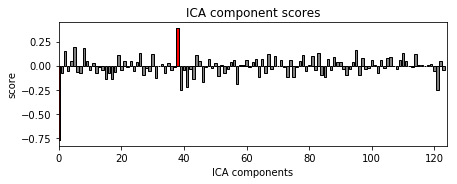

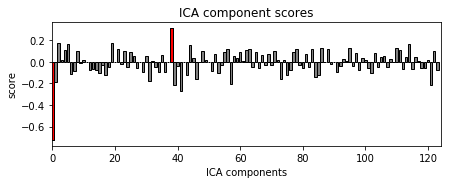

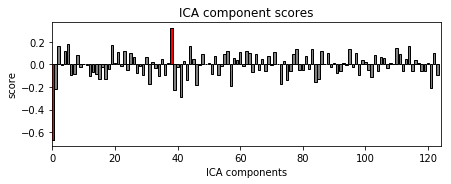

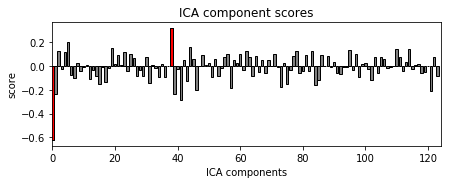

RuntimeError: By default, MNE does not load data into main memory to conserve ressources. ica.apply requires epochs data to be loaded. Use preload=True (or string) in the constructor or epochs.load_data().

In [229]:
eog_chs = ['E8', 'E14','E21','E25']
bad_ica_comps = []
for ch in eog_chs:
    inds, scores = ica.find_bads_eog(raw, ch_name=ch, threshold=2.5, l_freq=1, h_freq=8, verbose=False)
    bad_ica_comps.extend(inds)
    ica.plot_scores(scores, exclude=eog_inds)

bad_ica_comps = list(set(bad_ica_comps))
ica.exclude = bad_ica_comps
epochs = ica.apply(epochs)

In [101]:
epochs.save('test-epo.fif')

In [32]:
# Sanity check event time series
# epochs.plot();

In [ ]:
epochs.plot_sensors()

In [ ]:
epochs.average().plot?

In [ ]:
evoked = epochs.average()

In [ ]:
evoked.plot(exclude=[])

In [ ]:
epochs.plot()

In [ ]:
epochs.info['bads'] = bad_channels
#epochs.drop_channels(bad_channels)

In [ ]:
epochs._data.shape

### ICA

Note: can run ICA and automatically reject eye from corralation with very frontal channels: E127. E126

### Filtering

In [ ]:
# Filter setting
low_freq = 1
high_freq = 20

In [ ]:
# Filter EEG data
raw.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin')

### AutoReject

Note: only works on epoched trials

In [ ]:
# Initialize autoreject object
#ar = AutoReject()

In [ ]:
# Run AutoReject
#epochs, rej_log = ar.fit_transform(epochs, True)

# Analyses

At this point, the rest becomes specific to the particular analyses that need to be done.

In [ ]:
# Calcualte ERPs
evoked = epochs.average()

In [ ]:
# Plot ERPs
evoked.plot();

In [ ]:
# Check topographies across time
evoked.plot_topomap([-0.1, 0, 0.200, 0.4]);

## Save Out

ToDo: Save out MNE epoch objects.



#### Have: 3D matrix per trial type

#### Options:
- Save out npz files
- Save out MNE object files